In [3]:
import numpy as np
import shutil
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.notebook import tqdm
from collections import namedtuple
from multiprocessing import Pool
from itertools import repeat
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams.update({'font.size': 18})

from definitions import ROOT_DIR
from unc.utils import load_info

/Users/ruoyutao/Documents/uncertainty/venv/lib/python3.8/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [4]:
# COLORS

emerald = "#2ecc71"
turquoise = "#1abc9c"
peter_river = "#3498db"
sunflower = "#f1c40f"
alizarin = "#e74c3c"
pumpkin = "#d35400"
green_sea = "#16a085"
wisteria = "#8e44ad"
midnight_blue = "#2c3e50"


In [5]:
level = 8
# all_paths = {
# #     f'uf{level}a_cnn': Path(ROOT_DIR, 'results', f'uf{level}a_cnn'),
#     f'uf{level}m_cnn':  Path(ROOT_DIR, 'results', 'uf8_sweep_4m', f'uf{level}m_cnn'),
#     f'uf{level}m_cnn_lstm':  Path(ROOT_DIR, 'results', 'uf8_sweep_4m', f'uf{level}m_cnn_lstm'),
# }
# results_dir = Path(ROOT_DIR, 'results')
results_dir = Path(ROOT_DIR, 'results', 'results_uf8_12m_best')

# results_dir = Path(ROOT_DIR, 'results_full_uf8')

all_paths = {
    f'uf{level}a_cnn': results_dir / f'uf{level}a_cnn',
    f'uf{level}m_cnn':  results_dir / f'uf{level}m_cnn',
    f'uf{level}m_cnn_lstm':  results_dir / f'uf{level}m_cnn_lstm',
}

plot_info = {
    f'uf{level}a_cnn': {'color': midnight_blue, 'label': 'Ground-truth'},
    f'uf{level}m_cnn_lstm': {'color': sunflower, 'label': 'LSTM'},
    f'uf{level}m_cnn_lstm_unc': {'color': wisteria, 'label': 'LSTM + Aux inputs'},
    f'uf{level}m_cnn': {'color': green_sea, 'label': 'Normal'},
    f'uf{level}m_cnn_unc': {'color': pumpkin, 'label': 'Aux inputs'}
}

plot_order = [
    f'uf{level}a_cnn',
    f'uf{level}m_cnn',
    f'uf{level}m_cnn_lstm',
    f'uf{level}m_cnn_unc',
    f'uf{level}m_cnn_lstm_unc'
]
split_by = ['buffer_size', 'step_size', 'arch', 'uncertainty_decay', 'slip_prob', 'trunc', 'total_steps']
Args = namedtuple('args', split_by)


def moving_avg(x, mode='valid', w=100):
    return np.convolve(x, np.ones(w), mode=mode) / w

In [6]:
def process_dir(dir_path, split_by, w=10):
    all_results = {}

        
    for f in tqdm(list(dir_path.iterdir())):
        if f.suffix != ".npy":
            continue
        info = load_info(f)
        args = info['args'].item()
        if "arch" not in args:
            args['arch'] = 'nn'
            
        if args['trunc'] > 10:
            continue
        
        if args['total_steps'] < 12e6:
            continue
            
#         if args["arch"] == "cnn_lstm" and args["uncertainty_decay"] < 1.:
#             continue
#         if args["total_steps"] < 4e6:
#             continue
            
        
        reward = info['reward']
        offline_key = 'offline_eval_reward'
        if 'offline_eval_returns' in info:
            offline_key = 'offline_eval_returns'
        offline_returns = info[offline_key]

        hparams = Args(*tuple(args[s] for s in split_by))

        if hparams not in all_results:
            all_results[hparams] = []

        all_results[hparams].append((reward, offline_returns, args, f))


    
    return all_results

    

In [7]:
def group_by(dataset, key, label_head, groups=None, add_labels=None):
    grouped_data = {}
    for args, d in dataset.items():
        key_val = getattr(args, key)

        if groups is not None:
            assert add_labels is not None and len(add_labels) == len(groups)
            full_label = label_head
            grouped = False
            none_idx = None
            
            for i, g in enumerate(groups):
                add_label = False
                
                if g is not None and key_val in g:
                    if add_labels[i] is not None:
                        full_label += f'_{add_labels[none_idx]}' 
                    grouped = True
                    break
                elif g is None:
                    none_idx = i
                    
            if not grouped:
                if none_idx is None:
                    print(f"skipping {key_val}")
                else:
                    if add_labels[i] is not None:
                        full_label += f'_{add_labels[none_idx]}'
        else:     
            full_label = label_head + f'_{key}_{key_val}'
            
        if full_label not in grouped_data:
            grouped_data[full_label] = {}
        
        grouped_data[full_label][args] = d
    return grouped_data


In [8]:
raw_data = {}

for key, v in all_paths.items():
    processed = process_dir(v, split_by)
    raw_data[key] = processed

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

In [9]:
arg_example = list(raw_data[f'uf{level}m_cnn'].values())[0][0][2]
steps_per_eval = arg_example['offline_eval_freq']

In [10]:
key = 'uncertainty_decay'
split_files = [f'uf{level}m_cnn', f'uf{level}m_cnn_lstm']
unc_decay_groups = [[1.], None]
additional_labels = [None, 'unc']

new_raw = {}

for split_file in split_files:
    new_grouped = group_by(raw_data[split_file], key, split_file, groups=unc_decay_groups, add_labels=additional_labels)
    for k, v in new_grouped.items():
        new_raw[k] = v
        
for k, v in raw_data.items():
    if k not in split_files:
        new_raw[k] = v

In [11]:
no_slip_raw = {}
slip_raw = {}

for k, v in new_raw.items():
    new_v_slip = {}
    new_v_no_slip = {}
    
    for k_arg, v_arg in v.items():
        if k_arg.slip_prob > 0.:
            new_v_slip[k_arg] = v_arg
        else:
            new_v_no_slip[k_arg] = v_arg
    slip_raw[k] = new_v_slip
    no_slip_raw[k] = new_v_no_slip

In [12]:
# we average the discounted episodic rewards over the final 100 episodes.

def get_eps_max_over(data, eps_max_over=100):
    hparam_results = []
    for args, all_dis_rew in data.items():
        final_max = np.mean([np.mean(offline_rew[-eps_max_over:]) for online_rew, offline_rew, all_args, fname in all_dis_rew])
#         final_max = np.mean([np.mean(offline_rew) for online_rew, offline_rew, all_args, fname in all_dis_rew])

        fnames = [fname for _, _, _, fname in all_dis_rew]
        hparam_results.append((args, final_max, fnames))
    return hparam_results



In [11]:
max_overs_slip = {}

for g, v in slip_raw.items():
    max_overs_slip[g] = get_eps_max_over(v, eps_max_over=100)
    

In [12]:
# Get the best hyperparams based on the final 100 episodes
all_best_slip = {}
for key, v in max_overs_slip.items():
    all_best_slip[key] = sorted(v, key=lambda x : x[1], reverse=True)[0]

all_best_slip

{'uf8m_cnn_unc': (args(buffer_size=100000, step_size=1e-06, arch='cnn', uncertainty_decay=0.65, slip_prob=0.1, trunc=10, total_steps=12000000),
  26.501019999999997,
  [PosixPath('/Users/ruoyutao/Documents/uncertainty/results/results_uf8_12m_best/uf8m_cnn/f45604bed2e26c497b49f66412aa4d25_Fri Jul 15 08:50:08 2022.npy'),
   PosixPath('/Users/ruoyutao/Documents/uncertainty/results/results_uf8_12m_best/uf8m_cnn/d53aa96e94bf1c5b1221e989bed5e653_Mon Jul 18 10:38:34 2022.npy'),
   PosixPath('/Users/ruoyutao/Documents/uncertainty/results/results_uf8_12m_best/uf8m_cnn/8fdf3ba177fbf2343a6e36b6ec595d08_Fri Jul 15 08:50:09 2022.npy'),
   PosixPath('/Users/ruoyutao/Documents/uncertainty/results/results_uf8_12m_best/uf8m_cnn/7ccc6248dc887651897389366f0bf849_Fri Jul 15 09:39:08 2022.npy'),
   PosixPath('/Users/ruoyutao/Documents/uncertainty/results/results_uf8_12m_best/uf8m_cnn/7daa39f12590e1deaea5271524b38eee_Fri Jul 15 08:50:08 2022.npy'),
   PosixPath('/Users/ruoyutao/Documents/uncertainty/results

In [13]:
# copy_to = Path(ROOT_DIR, 'results_full_uf8')
# for arg, tup in all_best_slip.items():
#     f_lst = tup[-1]
#     specific_dir = arg
#     if arg.endswith('_unc'):
#         specific_dir = specific_dir[:-4]
#     copy_to_specific = copy_to / specific_dir
#     copy_to_specific.mkdir(exist_ok=True)
#     for f in f_lst:
#         shutil.copy(f, copy_to_specific)

In [14]:
# trunc = int(1e6)
all_mapped_data_slip = {}
for key, v in all_best_slip.items():
    arg = v[0]
#     all_mapped_data[key] = map_dis_rew_to_steps(new_raw[key][arg], trunc=trunc)
    all_seeds = [val[1].mean(axis=-1) for val in slip_raw[key][arg]]
    all_mapped_data_slip[key] = np.stack(all_seeds)
    


In [15]:
all_mapped_data_slip

{'uf8m_cnn_unc': array([[15.66, 16.24, 21.14, ..., 33.34, 28.36, 32.32],
        [14.92, 18.6 , 18.64, ..., 31.26, 32.12, 31.42],
        [ 4.76, 15.22, 17.5 , ..., 30.06, 31.38, 31.8 ],
        ...,
        [-0.6 ,  6.2 ,  8.06, ..., 31.26, 32.74, 31.82],
        [12.88, 14.42, 18.94, ..., 28.3 , 33.48, 31.24],
        [13.88, 10.88, 14.66, ..., 23.18, 18.2 , 23.  ]]),
 'uf8m_cnn': array([[ 7.76, 11.62, 16.8 , ..., 20.96, 18.34, 20.74],
        [10.78,  3.62, 17.3 , ..., 16.8 , 19.8 , 22.18],
        [ 0.42,  0.14,  0.14, ..., 20.96, 19.72, 18.32],
        ...,
        [10.9 , 11.32, 16.12, ..., 22.5 , 29.02, 27.62],
        [19.32, 16.88, 17.16, ..., 19.78, 20.94, 21.96],
        [16.14, 18.96, 14.34, ..., 17.6 , 20.8 , 19.38]]),
 'uf8m_cnn_lstm_unc': array([[12.38,  8.08, 10.74, ..., 17.  , 21.56, 17.4 ],
        [ 9.78, 14.72, 14.54, ..., 19.  , 16.8 , 21.  ],
        [10.3 ,  4.56, 20.86, ..., 22.72, 23.18, 21.22],
        ...,
        [13.18, 18.44,  5.26, ..., 24.38, 24.02, 23.1

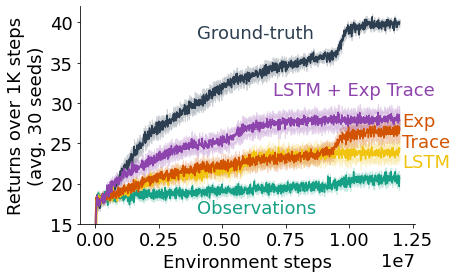

In [30]:
# with slip
fig, ax = plt.figure(), plt.axes()

fig_path = Path(ROOT_DIR, 'results', 'uf8_results.pdf')

for k in plot_order:
    data = all_mapped_data_slip[k]
    key = plot_info[k]['label']
    color = plot_info[k]['color']
    x = np.arange(data.shape[1]) * steps_per_eval

    means = data.mean(axis=0)
    std_err = data.std(axis=0) / np.sqrt(data.shape[0])

    ax.plot(x, means, label=key, color=color)
    plt.fill_between(x, means - std_err, means + std_err,
                         color=color, alpha=0.2)

ax.set_ylim(15, 42)
# ax.set_ylim(15, 30)

# ax.set_yticks([18, 22, 26])
ax.set_xlabel('Environment steps')
# ax.set_ylabel(f"Returns (1K steps)", rotation=0, labelpad=65)
ax.set_ylabel(f"Returns over 1K steps\n(avg. 30 seeds)")
# ax.yaxis.set_label_coords(-0.15, 0.65)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# plt.text(2e6, 16.3, "Observations", color=plot_info[f'uf{level}m_cnn']['color'], fontdict=dict(size=18))
plt.text(4e6, 16.3, "Observations", color=plot_info[f'uf{level}m_cnn']['color'], fontdict=dict(size=18))

# plt.text(1.5e6, 33.5, "Ground-truth", color=plot_info[f'uf{level}a_cnn']['color'], fontdict=dict(size=18))
plt.text(4e6, 38, "Ground-truth", color=plot_info[f'uf{level}a_cnn']['color'], fontdict=dict(size=18))
# plt.text(6.1e6, 24, "Exp\nTrace", color=plot_info[f'uf{level}m_cnn_unc']['color'], fontdict=dict(size=18))
plt.text(12.1e6, 24.5, "Exp\nTrace", color=plot_info[f'uf{level}m_cnn_unc']['color'], fontdict=dict(size=18))

# plt.text(6.1e6, 21.5, "LSTM", color=plot_info[f'uf{level}m_cnn_lstm']['color'], fontdict=dict(size=18))
plt.text(12.1e6, 22, "LSTM", color=plot_info[f'uf{level}m_cnn_lstm']['color'], fontdict=dict(size=18))

# plt.text(1.5e6, 27.5, "LSTM + Exp Trace", color=plot_info[f'uf{level}m_cnn_lstm_unc']['color'], fontdict=dict(size=18))
plt.text(7e6, 31, "LSTM + Exp Trace", color=plot_info[f'uf{level}m_cnn_lstm_unc']['color'], fontdict=dict(size=18))

# ax.set_title(f'Fishing Environment')

# plt.legend(bbox_to_anchor=(1.00, 1), loc='upper left')
fig.savefig(fig_path, bbox_inches='tight')



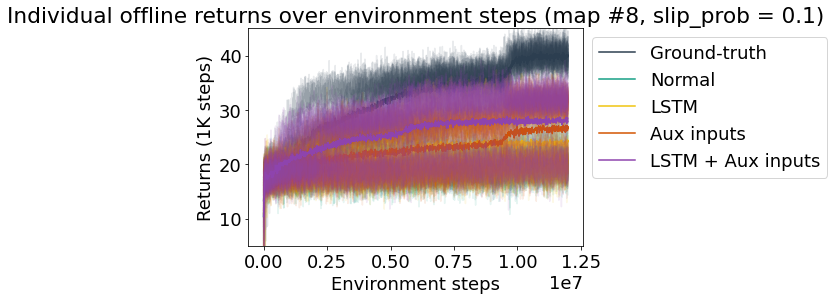

In [17]:
# with slip
fig, ax = plt.figure(), plt.axes()


for k in plot_order:
    data = all_mapped_data_slip[k]
    key = plot_info[k]['label']
    color = plot_info[k]['color']
    x = np.arange(data.shape[1]) * steps_per_eval

    means = data.mean(axis=0)
    ax.plot(x, means, label=key, color=color)

    for d in data:
        ax.plot(x, d, color=color, alpha=0.1)
#     plt.fill_between(x, means - std_err, means + std_err,
#                          color=color, alpha=0.2)

ax.set_ylim(5, 45)
    
ax.set_xlabel('Environment steps')
ax.set_ylabel(f"Returns (1K steps)")
ax.set_title(f'Individual offline returns over environment steps (map #8, slip_prob = 0.1)')
plt.legend(bbox_to_anchor=(1.00, 1), loc='upper left')

In [18]:
hparam_results_dir = Path(ROOT_DIR, 'results', 'results_uf8_12m_hparam')
all_hparam_paths = {
    f'uf{level}a_cnn': hparam_results_dir / f'uf{level}a_cnn',
    f'uf{level}m_cnn':  hparam_results_dir / f'uf{level}m_cnn',
    f'uf{level}m_cnn_lstm':  hparam_results_dir / f'uf{level}m_cnn_lstm',
}


In [19]:
raw_hparam_data = {}

for key, v in all_hparam_paths.items():
    processed = process_dir(v, split_by)
    raw_hparam_data[key] = processed

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/239 [00:00<?, ?it/s]

In [20]:
key = 'trunc'
split_files = [f'uf{level}m_cnn_lstm']
trunc_raw = {}

for split_file in split_files:
    new_grouped = group_by(raw_hparam_data[split_file], key, split_file)
    for k, v in new_grouped.items():
        trunc_raw[k] = v
        
# for k, v in raw_data.items():
#     if k not in split_files:
#         new_raw[k] = v

In [21]:
max_overs_trunc = {}

for g, v in trunc_raw.items():
    max_overs_trunc[g] = get_eps_max_over(v, eps_max_over=0)


In [22]:
# Get the best hyperparams based on the final 100 episodes
all_best_trunc = {}
for key, v in max_overs_trunc.items():
    filtered_v = [el for el in v if el[0].uncertainty_decay == 1.]
        
    all_best_trunc[key] = sorted(filtered_v, key=lambda x : x[1], reverse=True)[0]

all_best_trunc

{'uf8m_cnn_lstm_trunc_5': (args(buffer_size=100000, step_size=1e-06, arch='cnn_lstm', uncertainty_decay=1.0, slip_prob=0.1, trunc=5, total_steps=12000000),
  22.212120000000002,
  [PosixPath('/Users/ruoyutao/Documents/uncertainty/results/results_uf8_12m_hparam/uf8m_cnn_lstm/485a11b2b588fbd3d79da77ac3f201f3_Wed Jun 29 13:36:28 2022.npy'),
   PosixPath('/Users/ruoyutao/Documents/uncertainty/results/results_uf8_12m_hparam/uf8m_cnn_lstm/b3d5a1b2bf6c7a55c70922fe3447b5b8_Wed Jun 29 13:36:28 2022.npy'),
   PosixPath('/Users/ruoyutao/Documents/uncertainty/results/results_uf8_12m_hparam/uf8m_cnn_lstm/6411d59853e18f4499e11a2843672ec3_Wed Jun 29 13:36:28 2022.npy'),
   PosixPath('/Users/ruoyutao/Documents/uncertainty/results/results_uf8_12m_hparam/uf8m_cnn_lstm/82863906c675133dc79f7e5c9928e73c_Wed Jun 29 13:36:29 2022.npy'),
   PosixPath('/Users/ruoyutao/Documents/uncertainty/results/results_uf8_12m_hparam/uf8m_cnn_lstm/ae7af1329a72cfba94e4b68e1236a0f1_Wed Jun 29 13:46:25 2022.npy')]),
 'uf8m_cnn

In [23]:
# trunc = int(1e6)
all_mapped_data_trunc = {}

for key, v in all_best_trunc.items():
    arg = v[0]
#     all_mapped_data[key] = map_dis_rew_to_steps(new_raw[key][arg], trunc=trunc)
    all_seeds = [val[1].mean(axis=-1) for val in trunc_raw[key][arg]]
    all_mapped_data_trunc[key] = np.stack(all_seeds)
    


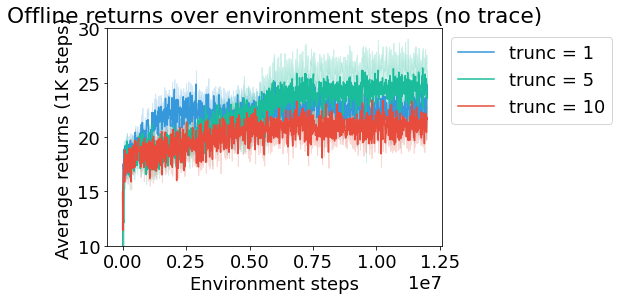

In [27]:
# with trunc

plot_info_trunc = {
    f'uf{level}m_cnn_lstm_trunc_1': {'color': peter_river, 'label': 'trunc = 1'},
    f'uf{level}m_cnn_lstm_trunc_5': {'color': turquoise, 'label': 'trunc = 5'},
    f'uf{level}m_cnn_lstm_trunc_10': {'color': alizarin, 'label': 'trunc = 10'},
#     f'uf{level}m_cnn_lstm_trunc_15': {'color': turquoise, 'label': 'trunc = 15'},
#     f'uf{level}m_cnn_lstm_trunc_20': {'color': sunflower, 'label': 'trunc = 20'}

}

fig, ax = plt.figure(), plt.axes()


for k, info in plot_info_trunc.items():
    data = all_mapped_data_trunc[k]
    key = info['label']
    color = info['color']
    x = np.arange(data.shape[1]) * steps_per_eval

    means = data.mean(axis=0)
    std_err = data.std(axis=0) / np.sqrt(data.shape[0])

    ax.plot(x, means, label=key, color=color)
    plt.fill_between(x, means - std_err, means + std_err,
                         color=color, alpha=0.2)
ax.set_ylim(10, 30)

ax.set_xlabel('Environment steps')
ax.set_ylabel(f"Average returns (1K steps)")
ax.set_title(f'Offline returns over environment steps (no trace)')
plt.legend(bbox_to_anchor=(1.00, 1), loc='upper left')

/var/folders/pq/j91zp9vj1jlb0l4g4kysybzr0000gn/T/ipykernel_69404/1078474429.py:14: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  ax.errorbar(x, mean, yerr=std_err, fmt='.k', label=key, color=color)
/var/folders/pq/j91zp9vj1jlb0l4g4kysybzr0000gn/T/ipykernel_69404/1078474429.py:14: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  ax.errorbar(x, mean, yerr=std_err, fmt='.k', label=key, color=color)
/var/folders/pq/j91zp9vj1jlb0l4g4kysybzr0000gn/T/ipykernel_69404/1078474429.py:14: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  ax.errorbar(x, mean, yerr=std_err, fmt='.k', label=key, color=color)


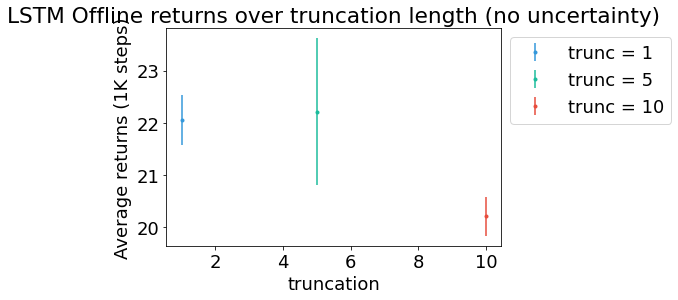

In [29]:
fig, ax = plt.figure(), plt.axes()


for k, info in plot_info_trunc.items():
    data = all_mapped_data_trunc[k]
    key = info['label']
    color = info['color']
    x = np.array([int(k.split('_')[-1])])

    step_means = data.mean(axis=-1)
    mean = step_means.mean(axis=0)
    std_err = step_means.std(axis=0) / np.sqrt(step_means.shape[0])

    ax.errorbar(x, mean, yerr=std_err, fmt='.k', label=key, color=color)
# ax.set_xlim(0, 11)
# ax.set_ylim(12, 18)

ax.set_xlabel('truncation')
ax.set_ylabel(f"Average returns (1K steps)")
ax.set_title(f'LSTM Offline returns over truncation length (no uncertainty)')
plt.legend(bbox_to_anchor=(1.00, 1), loc='upper left')

In [37]:
all_best_trunc_unfiltered = {}
for key, v in max_overs_trunc.items():
        
    all_best_trunc_unfiltered[key] = sorted(v, key=lambda x : x[1], reverse=True)[0]

# trunc = int(1e6)
all_mapped_data_trunc_unfiltered = {}

for key, v in all_best_trunc_unfiltered.items():
    arg = v[0]
#     all_mapped_data[key] = map_dis_rew_to_steps(new_raw[key][arg], trunc=trunc)
    all_seeds = [val[1].mean(axis=-1) for val in trunc_raw[key][arg]]
    all_mapped_data_trunc_unfiltered[key] = np.stack(all_seeds)
    
all_best_trunc_unfiltered

{'uf8m_cnn_lstm_trunc_5': (args(buffer_size=100000, step_size=1e-06, arch='cnn_lstm', uncertainty_decay=0.95, slip_prob=0.1, trunc=5, total_steps=12000000),
  27.383266666666668,
  [PosixPath('/Users/ruoyutao/Documents/uncertainty/results/results_uf8_12m_hparam/uf8m_cnn_lstm/eb6c44879c55b0e1be93228d5c02c353_Wed Jun 29 13:46:25 2022.npy'),
   PosixPath('/Users/ruoyutao/Documents/uncertainty/results/results_uf8_12m_hparam/uf8m_cnn_lstm/82eb4a9ff4d1f4502f38e5c8d5729c76_Wed Jun 29 13:55:32 2022.npy'),
   PosixPath('/Users/ruoyutao/Documents/uncertainty/results/results_uf8_12m_hparam/uf8m_cnn_lstm/61432838d6884ecfeefe262afe2ae87a_Wed Jun 29 13:55:32 2022.npy'),
   PosixPath('/Users/ruoyutao/Documents/uncertainty/results/results_uf8_12m_hparam/uf8m_cnn_lstm/a3bbe5cc86de7488ba9310196ba46c4a_Wed Jun 29 13:55:32 2022.npy'),
   PosixPath('/Users/ruoyutao/Documents/uncertainty/results/results_uf8_12m_hparam/uf8m_cnn_lstm/c5fe2cc6247224637bf0f5591f1ffeef_Wed Jun 29 13:55:32 2022.npy')]),
 'uf8m_cn

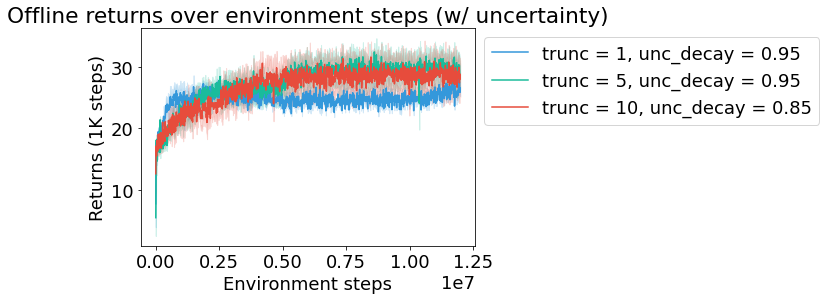

In [38]:
# with trunc

plot_info_trunc_unfiltered = {
    f'uf{level}m_cnn_lstm_trunc_1': {'color': peter_river, 'label': f'trunc = 1, unc_decay = {all_best_trunc_unfiltered[f"uf{level}m_cnn_lstm_trunc_1"][0].uncertainty_decay}'},
    f'uf{level}m_cnn_lstm_trunc_5': {'color': turquoise, 'label': f'trunc = 5, unc_decay = {all_best_trunc_unfiltered[f"uf{level}m_cnn_lstm_trunc_5"][0].uncertainty_decay}'},
    f'uf{level}m_cnn_lstm_trunc_10': {'color': alizarin, 'label': f'trunc = 10, unc_decay = {all_best_trunc_unfiltered[f"uf{level}m_cnn_lstm_trunc_10"][0].uncertainty_decay}'},
#     f'uf{level}m_cnn_lstm_trunc_15': {'color': alizarin, 'label': f'trunc = 10, unc_decay = {all_best_trunc_unfiltered[f"uf{level}m_cnn_lstm_trunc_10"][0].uncertainty_decay}'}
#     f'uf{level}m_cnn_lstm_trunc_20': {'color': sunflower, 'label': f'trunc = 20, unc_decay = {all_best_trunc_unfiltered[f"uf{level}m_cnn_lstm_trunc_20"][0].uncertainty_decay}'}

}


fig, ax = plt.figure(), plt.axes()


for k, info in plot_info_trunc_unfiltered.items():
    data = all_mapped_data_trunc_unfiltered[k]
    key = info['label']
    color = info['color']
    x = np.arange(data.shape[1]) * steps_per_eval

    means = data.mean(axis=0)
    std_err = data.std(axis=0) / np.sqrt(data.shape[0])

    ax.plot(x, means, label=key, color=color)
    plt.fill_between(x, means - std_err, means + std_err,
                         color=color, alpha=0.2)

ax.set_xlabel('Environment steps')
ax.set_ylabel(f"Returns (1K steps)")
ax.set_title(f'Offline returns over environment steps (w/ uncertainty)')
plt.legend(bbox_to_anchor=(1.00, 1), loc='upper left')

k: 1, step_means: [24.73165    25.25301667 23.96221667 24.48705    25.25215   ]
k: 5, step_means: [29.24743333 29.38298333 19.36965    29.23163333 29.68463333]
k: 10, step_means: [28.653      29.4186     19.16151667 29.83978333]


/var/folders/pq/j91zp9vj1jlb0l4g4kysybzr0000gn/T/ipykernel_55264/2887478013.py:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  ax.errorbar(x, mean, yerr=std_err, fmt='.k', label=key, color=color)
/var/folders/pq/j91zp9vj1jlb0l4g4kysybzr0000gn/T/ipykernel_55264/2887478013.py:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  ax.errorbar(x, mean, yerr=std_err, fmt='.k', label=key, color=color)
/var/folders/pq/j91zp9vj1jlb0l4g4kysybzr0000gn/T/ipykernel_55264/2887478013.py:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  ax.errorbar(x, mean, yerr=std_err, fmt='.k', label=key, color=color)


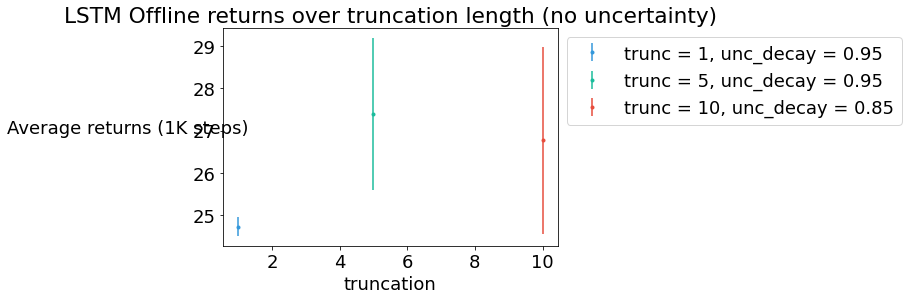

In [39]:
fig, ax = plt.figure(), plt.axes()


for k, info in plot_info_trunc_unfiltered.items():
    data = all_mapped_data_trunc_unfiltered[k]
    key = info['label']
    color = info['color']
    x = np.array([int(k.split('_')[-1])])

    step_means = data.mean(axis=-1)
    mean = step_means.mean(axis=0)
    std_err = step_means.std(axis=0) / np.sqrt(step_means.shape[0])
    print(f"k: {x.item()}, step_means: {step_means}")

    ax.errorbar(x, mean, yerr=std_err, fmt='.k', label=key, color=color)
# ax.set_xlim(0, 11)
# ax.set_ylim(12, 18)

ax.set_xlabel('truncation')
ax.set_ylabel(f"Average returns (1K steps)", rotation=0, labelpad=65)
ax.set_title(f'LSTM Offline returns over truncation length (no uncertainty)')
plt.legend(bbox_to_anchor=(1.00, 1), loc='upper left')